In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import math

In [202]:
#read file to input
df = pd.read_csv('data_banknote_authentication.txt', sep=',', header = None)
X = df.to_numpy()
y = df[4].to_numpy()
X = X[:, :4]

In [203]:
class node: 
    #instance attributes
    def __init__(self, data, parent = None, majority_label = None):
        # data contains a feature for inner nodes and the label for every leaf
        self.data = data
        self.parent = parent
        self.majority_label = majority_label
        #if children is empty, the node is a leaf -> data contains a label
        self.children = [] #map value -> node // list of tuples
    def __str__(self):
        return f"{self.data} - {self.children}"
    def addChild(self, child):
        self.children.append(child)

In [204]:
def learn(X, y, impurity_measure = 'entropy', pruning = True):
    seed = 432
#check pruning/training rate
    X_train, X_prun, Y_train, Y_prun = model_selection.train_test_split(X, y, test_size= 0.3, shuffle=True,                                                                                 random_state = seed)
    root = learn_rec(X_train, Y_train, [], impurity_measure)
    if pruning:
        root = pruning_function(root, X_prun, Y_prun)
    return root

def learn_rec(X, y, used_features, impurity_measure = 'entropy'):
    #Ensure used_feature is of type list
    used_feature_list = used_features
    if(not isinstance(used_feature_list, list)):
        used_feature_list = []
    if same_value(y):
        print("Case: Same value y")
        #create a leaf with the label -> all labels are the same so we pick an arbitrary label
        return node(y[0])
    elif same_value(X) or len(used_feature_list)==len(X[0]):
        print("Case: all features used or same value X")
        #leaf with most common label
        label = get_maj_label(y)
        return node(label)
    else:
        #select the desired feature based on impurity measure
        feature = max_information_gain(X, y, impurity_measure, used_feature_list)
        used_feature_list.append(feature)
        print("Selected Feature: "+str(feature))
        #create feature node and split the dataset
        f_node = node(feature, majority_label = get_maj_label(y))
        X_right, X_left, y_right, y_left, val_avg = split_dataset(X, y, feature)
        #create child nodes and set their parents
        print("Look at right child")
        print("Used_feature_list before for selected Feature "+ str(feature)+": "+str(used_feature_list))
        right_child = learn_rec(np.array(X_right), y_right,  used_feature_list, impurity_measure)
        print("Used_feature_list after for selected Feature "+ str(feature)+": "+str(used_feature_list))
        right_child.parent = f_node

        print("Look at left child")
        left_child = learn_rec(np.array(X_left), y_left,  used_feature_list, impurity_measure)
        print("Used_feature_list after for selected Feature "+ str(feature)+": "+str(used_feature_list))
     #   print("Selected feature: ", feature, "  new Matrix: ", delete_feature_from_matrix(X_left, feature))
        left_child.parent = f_node
        #add children to featurenode
        f_node.addChild([left_child, val_avg])
        f_node.addChild([right_child, val_avg])
        return f_node


def predict(node, x):
    count_values = len(node.children)
    for i in range(count_values):
        if (not node.children):                             #empty children list --> leaf
            print("Node.data = " + str(node.data))
            return node.data
        elif(i == count_values-1):                          #Last value in list --> x > elements in this tree
            predict(node.children[i][0], x)                 
        elif(x[node.data] < node.children[i][1]):           
            predict(node.children[i][0],x)                  

def pruning_function(node, X_prun, y_prun):                  #starts with root + recursion
    if (node.children):                                      #the subtree is not a leaf
        if (acc(node, X_prun, y_prun) < majority_label_acc(node.majority_label, y_prun)):
            node.data = node.majority_label
            node.children = []
        else: 
            for i in range(len(node.children)):
                pruning((node.children[i])[1], X_prun, y_prun) #call recursion on each child
    return node

In [205]:
#hilfsfunktionen
def same_value(list_in):
    flat_array = np.ravel(list_in)
    return np.all(list_in==flat_array[0])
def common_label(y):
    dict = {} 
    count = 0
    item_ret = ''
    for item in y: 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, item_ret = dict[item], item 
    return(item_ret) 
def sort_with_index(liste):
    temp_list = [ (liste[i],i) for i in range(len(liste)) ]
    temp_list.sort()
    return zip(*temp_list)

def split_indices(index, y):
    splitpoints = []
    temp = index[0]
    for i in range(len(index)):
        if y[index[i]] != y[temp]:
            #add current pair
            splitpoints.append([temp, index[i]])
            #start with next featurepoint
            temp = index[i+1]
    return splitpoints
def max_information_gain(X, y, impurity_measure = 'entropy', used_feature=[]):
    max_ig = 0
    max_label = 0
    Feature_indizes = []
    if(not isinstance(used_feature, list)):
        used_feature=[]
    for i in range(len(X[0])):
        if(i not in used_feature):
            Feature_indizes.append(i)
    for i in Feature_indizes:
        x = X[:, i]
        ig = information_gain(x, y, impurity_measure)
        if ig > max_ig:
            max_ig = ig
            max_label = i
    return max_label
def split_dataset(X, y, feature):
    feature_values = X[:, feature]
    average = np.average(feature_values)
    X_right = []
    X_left = []
    y_right = []
    y_left = []
    for i in range(len(feature_values)):
        if feature_values[i] <= average:
            X_left.append(X[i])
            y_left.append(y[i])
        else:
            X_right.append(X[i])
            y_right.append(y[i])
    return X_right, X_left, y_right, y_left, average
def get_maj_label(y):
    label_list = []
    count_list = []
    for i in range(len(y)):
        if (y[i] not in label_list): 
            label_list.append(y[i])
            count_list.append(1)
        else:
            for j in range(len(label_list)):
                if(y[i]==label_list[j]): count_list[j]+=1
    return label_list[np.argmax(count_list)]
def majority_label_acc(majority_label, y_prun):
    x = 0
    for i in range(len(y_prun)):
        if(y_prun[i]==majority_label):
            x += 1
    return float(x) / len(y_prun)

def acc(node, X, Y):
    x = 0
    for i in range(len(Y)):
        if(Y[i]==predict(node, X[i,:])):
            x += 1
    return float(x) / len(Y)

In [206]:
#Implementation of Impurity-Measures
def information_gain(x, y, impurity_measure="entropy"):
    #Calculate mean value of x
    mean = 0
    count = 0
    for i in range(len(x)):
        mean += x[i]
        count +=1
    mean /= count

    #compute list of label_values for x<=mean or x>mean + probability of x <= mean
    leq_mean = []
    g_mean = []
    count_leq_mean = 0
    for i in range(len(x)):
        if(x[i] <= mean):
            count_leq_mean +=1
            leq_mean.append(y[i])
        else:
            g_mean.append(y[i])
    prob_leq_mean = count_leq_mean / count

    #compute H(y), H(y|x)
    if(impurity_measure=="entropy"):
        impurity = entropy(y)
        conditional_impurity = prob_leq_mean * entropy(leq_mean)+ (1-prob_leq_mean) * entropy(g_mean)
    elif(impurity_measure=="gini"):
        impurity = gini(y)
        conditional_impurity = prob_leq_mean * gini(leq_mean)+ (1-prob_leq_mean) * gini(g_mean) 
    else:
        print("Not known impurity measure")

    #Information gain IG = H(y) - H(y|x)
    return impurity - conditional_impurity

def probabiliy_list(values):
    count_values = len(values)
    value_list = []
    prob_list = []
    different_val = 0
    #compute list of the count of different values (unsorted)
    for i in range(count_values):
        if (values[i] not in value_list): 
            value_list.append(values[i])
            prob_list.append(1)
            different_val +=1
        else:
            for j in range(different_val):
                if(values[i]==value_list[j]): prob_list[j]+=1
    #get probabilities of different values by count[value] / count_all_values
    for k in range(different_val):
        prob_list[k] = float(prob_list[k]) / count_values
    #Remark: this is an unsorted list of only the probabilities --> no information about the original values
    return prob_list 

def entropy(values):
    prob_list = probabiliy_list(values)
    different_values = len(prob_list)
    sum = 0
    for i in range(different_values):
        sum -= math.log(prob_list[i], 2) * prob_list[i]
    return sum

def gini(values):
    prob_list = probabiliy_list(values)
    different_values = len(prob_list)
    sum = 0
    for i in range(different_values):
        sum += prob_list[i]*(1-prob_list[i])
    return sum

In [207]:
#Unused help functions
def delete_column(x,index):
    return np.delete(x,index,0)
def delete_feature_from_matrix(X, Feature_index):
    return np.delete(X, Feature_index, 1)#Feature is Axis 1


Selected Feature: 0
Look at right child
Used_feature_list before for selected Feature 0: [0]
Selected Feature: 2
Look at right child
Used_feature_list before for selected Feature 2: [0, 2]
Selected Feature: 1
Look at right child
Used_feature_list before for selected Feature 1: [0, 2, 1]
Case: Same value y
Used_feature_list after for selected Feature 1: [0, 2, 1]
Look at left child
Selected Feature: 3
Look at right child
Used_feature_list before for selected Feature 3: [0, 2, 1, 3]
Case: all features used or same value X
Used_feature_list after for selected Feature 3: [0, 2, 1, 3]
Look at left child
Case: Same value y
Used_feature_list after for selected Feature 3: [0, 2, 1, 3]
Used_feature_list after for selected Feature 1: [0, 2, 1, 3]
Used_feature_list after for selected Feature 2: [0, 2, 1, 3]
Look at left child
Case: all features used or same value X
Used_feature_list after for selected Feature 2: [0, 2, 1, 3]
Used_feature_list after for selected Feature 0: [0, 2, 1, 3]
Look at lef

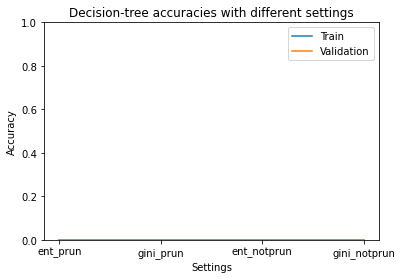

In [208]:
#Evaluation
seed = 666
X_train, X_val_test, Y_train, Y_val_test = model_selection.train_test_split(X, y, test_size= 0.3, shuffle=True,                                                                                     random_state = seed)
seed = 221
X_val, X_test, Y_val, Y_test = model_selection.train_test_split(X_val_test, Y_val_test, test_size= 0.5, shuffle=True,                                                                                     random_state = seed)
#We now have ratio training-, validation-, testdata: 0.7, 0.15, 0.15

#Train decisiontree using entropy + pruning
tree_ent_prun = learn(X_train, Y_train, impurity_measure="entropy", pruning=True)
val_acc_ent_prun = acc(tree_ent_prun, X_val, Y_val)
train_acc_ent_prun = acc(tree_ent_prun, X_train, Y_val)
print("-----")

#Train decisiontree using gini + pruning
tree_gini_prun = learn(X_train, Y_train, impurity_measure="gini", pruning=True)
val_acc_gini_prun = acc(tree_gini_prun, X_val, Y_val)
train_acc_gini_prun = acc(tree_gini_prun, X_train, Y_val)
print("-----")

#Train decisiontree using entropy and not pruning
tree_ent_notprun = learn(X_train, Y_train, impurity_measure="entropy", pruning=False)
val_acc_ent_notprun = acc(tree_ent_notprun, X_val, Y_val)
train_acc_ent_notprun = acc(tree_ent_notprun, X_train, Y_train)
print("------")

#Train decisiontree using gini and not pruning
tree_gini_notprun = learn(X_train, Y_train, impurity_measure="gini", pruning=False)
val_acc_gini_notprun = acc(tree_gini_notprun, X_val, Y_val)
train_acc_gini_notprun = acc(tree_gini_notprun, X_train, Y_train)

#plot accuracies
settings_list = ["ent_prun", "gini_prun","ent_notprun", "gini_notprun"]
train_accuracies = [train_acc_ent_prun, train_acc_gini_prun, train_acc_ent_notprun, train_acc_gini_notprun]
val_accuracies = [val_acc_ent_prun, val_acc_gini_prun, val_acc_ent_notprun, val_acc_gini_notprun]
plt.plot(settings_list, train_accuracies)
plt.plot(settings_list, val_accuracies)
plt.ylim(0, 1)
plt.xlabel('Settings')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='best')
plt.title("Decision-tree accuracies with different settings")

plt.show()